# Diagnosis of COVID-19 Using Raman Spectroscopy

### Kyle Lombardo
#### College of IT, Western Governors University, Salt Lake City, Utah

## Introduction

In 2020 an RNA virus, known as COVID-19 — a novel coronavirus, became the first world-wide pandemic in decades. The virus, which targets the respiratory system of its victims, has claimed over 6.2 million lives worldwide.<sup>1</sup> Healthcare systems around the world have struggled to test and to isolate patients in a rapid and effective manner. For the first few months of the pandemic, testing was a laborious and lengthy affair using either reverse transcription quantitative polymerase chain reaction (RT-qPCR)<sup>2</sup> or serological enzyme-linked immunosorbent assay (ELISA), two expensive and time-consuming tests. For a highly contagious virus, results were often too slow to alert a patient whether they did or did not have COVID-19. 

A new approach — first discussed by Yin, et al.<sup>3</sup> — uses Raman spectroscopy to classify whether a serum sample contains strands of COVID-19. “Raman spectroscopy is a method that detects molecular vibration and molecular rotation energy levels”<sup>3</sup> in a non-destructive manner. The infrared light is shone on a sample causing the molecular bonds to vibrate at specific frequencies as they absorb light energy. The more concentrated a specific type of molecule is, and its respective bonds, the higher the intensity of signal given from the vibration. This relationship between signal and concentration is known as Beer-Lambert’s law. It is because of these varying intensities at the different frequencies, the presence of molecules or larger-chained molecules such as a virus can be detected and quantified using machine learning techniques.

Yin, et al. has a portion of their data set available on Kaggle.com, released under a Public Domain License in CSV format.<sup>5</sup> The data set contains 310 sample spectra labeled with either a positive or negative COVID diagnosis with 901 wavelengths as the column features. 

Chen<sup>4</sup> analyzed this data set using various classification models such as logistic regression, after cleaning and derivatizing the spectra and performing PCA to reduce features. This paper builds off Chen’s work and will provide an in-depth study on logistic regression and whether logistic regression can provide a statistically significant model for predicting COVID-19 using Raman spectroscopy. 

## Research Question

Using the correct preparation, feature reduction, and data cleaning techniques, a machine learning classification model such as logistic regression should be able to identify whether a sample contains strands of the COVID-19 virus. The question this paper attempts to answer is, can logistic regression provide a statistically significant prediction model for diagnosing whether a patient is infected with COVID-19 to help reduce misdiagnoses and provide proper care for the patient? 

The purposes of answering this question are, (1) providing statistical significance to the model which Chen has created, and (2) produce a model for rapid testing of COVID-19 using Raman spectroscopy. While Chen’s paper gives insight into the effectiveness of various models, none of models are proven to be statistically significant, nor do they yield the p-values for the features used in the models. While the accuracy reported was admirable, there is no proof of the actual effectiveness of the model. This report will focus solely on logistic regression classification and will explore whether the logistic regression does or does not reject null hypothesis:

H<sub>O</sub>: Logistic regression cannot predict if a sample contains COVID in a statistically significant manner.               

H<sub>A</sub>: Logistic regression can predict if a sample contains COVID in a statistically significant manner.

The second purpose of this paper is to establish a method for rapid COVID-19 testing. With the RT-qPCR and ELISA methods requiring such lengthy time commitments, a rapid, accurate, and inexpensive method for testing COVID-19 serum samples would prove useful for business purposes. After the initial upfront cost of purchasing a Raman spectrometer, there are no costs for consumables or chemicals in contrast with the other two methods. According to Chen, logistic regression, a supervised learning model used in this report, should approach a 97% accuracy, an acceptable result compared to the golden standard methods mentioned previously.<sup>4</sup> 

## Data Collection

The data used in this report is part of the same data used in the research paper by Yin, et al.<sup>3</sup> It was found on Kaggle.com in CSV format under a Public Domain License.<sup>5</sup> Using data found in CSV format online saves time, resources, and expenses of purchasing a Raman spectrometer. The study published by Yin, et al.<sup>3</sup> would have required hours of sample collection and analysis. While running only a few samples with Raman spectroscopy can be rapid, running over 300 would still require a dedicated technician to scan the samples. Downloading the data sets from a reputable paper gives a quick analysis of the effectiveness of using Raman spectroscopy for COVID-19 diagnosis.

While convenient, there are a few small discrepancies in wavelengths. Typically, spectroscopy data comes in evenly distributed wavelengths (usually increasing in single integers); however, this data set contains sporadic wavelengths with gap sizes ranging from 1–3 nm. While not detrimental to the analysis, a higher frequency of wavelengths would impart more information. While having less features likely could help alleviate some of the multicollinearity, having the option for more wavelengths is potentially advantageous. 

Also, having not collected the data personally, there is no way of knowing the accuracy of the data collection. In all spectrometers, there are methods for measuring an accurate Raman spectroscopy which cannot be guaranteed in this data set.  All spectrometric methods require an even, homogenous sample, free from any outside influences. For instance, the presence of bubbles in a sample could hinder the reading of the sample due the uneven distribution of sample. This can negatively influence the way light interacts with the sample and give inaccurate light intensity readings.

## Data Extraction and Preparation

### Libraries

As with working will all types of data, the necessary libraries are needed for running the analysis. The libraries used for the data extraction and preparation stages are:  

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

The Pandas library is used for a large portion of the data organization, importation, and manipulation. It acts in a similar manner to SQL and allows for ease of access to a specific value found in the data set. Pandas is built upon the Numpy library, a library used to place data in multidimensional arrays. Matplotlib is a visualization tool and will be used for all the visualizations in this paper. Seaborn enhances the capability of matplotlib and provides different aesthetics. 

Scipy is a mathematical heavy library used for linear algebra, integrations, and other useful statistical analysis. It will be used in this paper for two statistical cleaning methods: `zscore()` and `savgol_filter()` which will be discussed later.  “Scikit-learn is an open-source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection, model evaluation, and many other utilities.”<sup>6</sup> Scikit-learn will be used in this paper for `PCA`, `train_test_split()`, and various metrics which will be covered when used later. 

### Data Extraction and Initial Exploration

Pandas is used to import the csv file and setting it to a variable. The first few rows of the data are viewed using `df.head()`. The entire data frame is also checked for nulls which return with 0 results.

In [37]:
df = pd.read_csv('covid_and_healthy_spectra.csv')
df.head()

,400,402,405,407,410,412,415,417,420,422,...,2101,2103,2104,2105,2107,2108,2109,2111,2112,diagnostic
0,0.0,-0.015237,-0.030607,-0.038309,-0.039078,-0.035809,-0.031176,-0.030395,-0.033311,-0.031603,...,-0.000553,0.000118,0.000566,0.001245,0.000846,0.001106,0.001005,0.000117,0.0,Healthy
1,0.0,-0.012098,-0.028164,-0.035189,-0.036138,-0.031050,-0.026015,-0.027539,-0.028084,-0.027075,...,-0.000998,0.000278,-0.000123,0.000384,0.001010,0.000583,-0.000397,-0.000160,0.0,Healthy
2,0.0,-0.013000,-0.029058,-0.035021,-0.034994,-0.033025,-0.028413,-0.028470,-0.029737,-0.029198,...,-0.001554,0.000050,0.000866,0.000877,0.000871,0.001093,0.001058,0.000614,0.0,Healthy
3,0.0,-0.015728,-0.034346,-0.045140,-0.047671,-0.044334,-0.040807,-0.040474,-0.041417,-0.040699,...,-0.001541,-0.000198,0.000202,0.001023,0.000625,0.000420,0.000543,-0.000071,0.0,Healthy
4,0.0,-0.020355,-0.045839,-0.060556,-0.065805,-0.064988,-0.062097,-0.061955,-0.064759,-0.066886,...,-0.000088,0.000891,0.000942,0.001294,0.001878,0.001739,0.001946,0.001301,0.0,Healthy


In [38]:
df.isnull().sum().sum()

0

Further investigation shows the two peripheral wavelengths, 400 and 2112, are zeroes columns. These can be dropped when setting the wavelengths as the X feature variable. The y variable can also be created from the original data for the classification. It will also need to be transformed to integer values using the one-hot encoding method `pd.get_dummies()` from Pandas. The generic name from the one-hot encoding column name is replaced with something more meaningful such as ‘Positive’, meaning a positive COVID-19 result.

The `X` features can be explored with the `describe()` function which shows the basic statistics of the data including mean, standard deviation, min/max, and interquartile values of the numeric columns. 

In [39]:
X = df.loc[:, '402':'2111']

y = np.array(df.diagnostic)
y = pd.get_dummies(y, drop_first=True)
y = y.rename(columns={'SARS-CoV-2': "Positive"})

X.describe()

,402,405,407,410,412,415,417,420,422,425,...,2099,2100,2101,2103,2104,2105,2107,2108,2109,2111
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,...,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,-0.015380,-0.029039,-0.034453,-0.034902,-0.032640,-0.029887,-0.029552,-0.030194,-0.029093,-0.026646,...,-0.003571,-0.001951,-0.000781,0.000078,0.000814,0.001197,0.001420,0.001327,0.000953,0.000617
std,0.004866,0.009268,0.012563,0.014003,0.014396,0.014464,0.014713,0.015658,0.016331,0.016623,...,0.001012,0.000880,0.000853,0.000893,0.000901,0.000929,0.000931,0.000844,0.000820,0.000701
min,-0.034126,-0.060028,-0.074953,-0.078206,-0.080790,-0.078527,-0.078364,-0.082074,-0.083183,-0.080005,...,-0.006856,-0.004929,-0.004929,-0.004931,-0.005235,-0.005087,-0.005610,-0.003002,-0.001769,-0.001797
25%,-0.018181,-0.034307,-0.041575,-0.042218,-0.039065,-0.035558,-0.035993,-0.038297,-0.037123,-0.035028,...,-0.004152,-0.002476,-0.001307,-0.000415,0.000345,0.000721,0.000960,0.000858,0.000472,0.000217
50%,-0.014863,-0.028215,-0.033517,-0.033892,-0.030718,-0.028413,-0.027639,-0.028696,-0.027925,-0.025483,...,-0.003612,-0.001989,-0.000714,0.000110,0.000799,0.001217,0.001439,0.001391,0.001023,0.000665
75%,-0.012075,-0.022868,-0.025739,-0.025721,-0.023546,-0.020764,-0.020656,-0.020443,-0.018591,-0.015469,...,-0.003044,-0.001447,-0.000292,0.000583,0.001288,0.001754,0.001949,0.001818,0.001466,0.001109
max,-0.002219,-0.006413,-0.006682,-0.004706,0.000129,0.005030,0.008210,0.010452,0.010410,0.012379,...,0.002312,0.002100,0.003037,0.003548,0.003594,0.004018,0.003570,0.003849,0.003291,0.002451


It is hard to understand and visualize what is happening by observing the slice of raw data in tabular form. All sample data, ignoring labels, is shown below in line graphs or how spectra are typically visualized, along with the matplotlib/seaborn code to plot it.

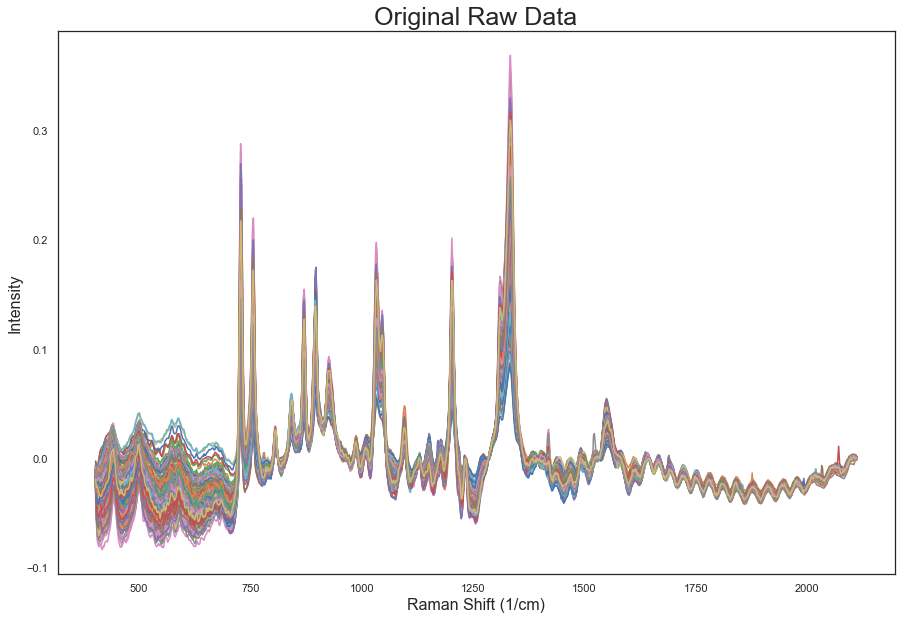

In [40]:
SPEC_RANGE = np.linspace(402, 2111, 898)

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(SPEC_RANGE, X.values.T)
ax.set_xlabel('Raman Shift (1/cm)', fontsize=16)
ax.set_ylabel('Intensity', fontsize=16)
ax.set_title('Original Raw Data', fontsize=25)
fig.savefig('Original spectra.png');

With over 300 samples, there is quite a bit of overlap between the samples. It is also worth noting the broad area from about 400–750nm. This is likely not variation between samples, but something known as the scattering effect. This occurs when there are different particle sizes in a sample. The light shines on the particle and scatters in different directions. Different particle sizes for different samples, gives variability to the signal output. The scattering effect can be combatted in two different ways: through a scattering correction method or using mathematical derivations.<sup>7</sup> Scattering effect correction will be performed in the data cleaning section below.

Imbalanced data can be a huge detriment to the accuracy, precision, and recall of a classification model. If there are too many of a certain class, the data will favor the class with more entries to the detriment of the minority class. While the accuracy may still be high, the recall or precision (depending on the ratio of classes) will be negatively affected. 

The unique values counts were plotted below and indicate the class data is well balanced and will require no additional manipulation. 

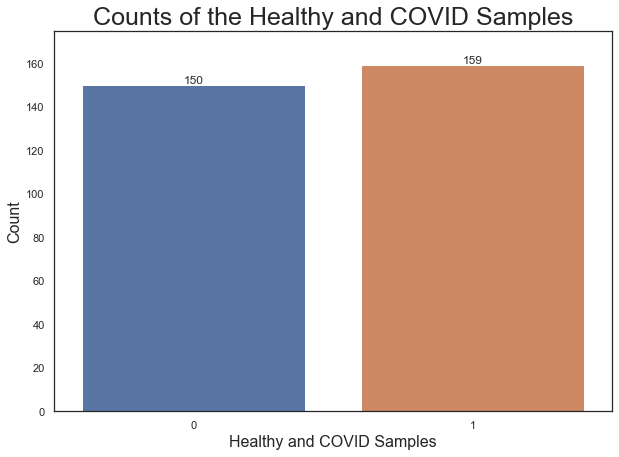

In [41]:
(unique, counts) = np.unique(y['Positive'], return_counts=True)

sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.barplot(x=[unique[0], unique[1]], y=counts)
ax.bar_label(ax.containers[0])
ax.set_title("Counts of the Healthy and COVID Samples", fontsize=25)
ax.set_xlabel("Healthy and COVID Samples", fontsize=16)
ax.set_ylim(0, 175)
ax.set_ylabel("Count", fontsize=16)
fig.savefig('Class_count.png');

### Outliers

Identification and elimination of outliers is crucial for obtaining accurate training models. However, identifying outlier in spectroscopy data is difficult due to the relationships between wavelengths. Z-scores are a commonly used outlier detection equation that center each value to the average and reduce the range by dividing by the standard deviation.

$$ 
Zscore = \frac{(X-\bar{X})}{S_X}
$$

The Statsmodels `zscore()` function makes this simple equation even easier. If all rows with a z-score of higher than the typical threshold of 3 were to be eliminated, all the data would be eliminated due to the fluctuating nature of spectra. One workaround is to count the number of z-scores over the 3-threshold for each row. If the number of wavelength outliers exceeds a certain percentage for a given row, such as 40%, then the row is deemed too radical and dropped.<sup>7</sup>


In [42]:
def z_score_eliminator(X, threshold):
    z_scores = zscore(X)

    for index, i in enumerate(range(z_scores.shape[0])):
        counter = 0
        for j in range(z_scores.shape[1]):
            if z_scores.iloc[i,j] > 3:
                counter += 1
        if counter > (z_scores.shape[0] * threshold):
            print(index, counter)

z_score_eliminator(X, 0.4)


51 190
258 127


A python function was created that accepted an input data frame and a threshold value. It loops through each row, finds all the columns with a z-score higher than 3 and counts them. If the number counted exceeds the threshold percentage value, it prints off the index of the row and number of columns over 3. With the indexes and outlier rows identified, they can be dropped from the data frame with the pandas drop function. To fill in the gaps from the missing rows the index is reset, and the old index dropped.

In [43]:
X = X.drop([51, 258]).reset_index().drop('index', axis=1)
y = y.drop([51, 258]).reset_index().drop('index', axis=1)

### Statistical Exploration

Visualizing the mean and standard deviation of all wavelengths provides insight into which wavelengths contain the most variation. After scattering correction, the standard deviation plot should have noticeably different variation, ideal for optimal the PCA later.

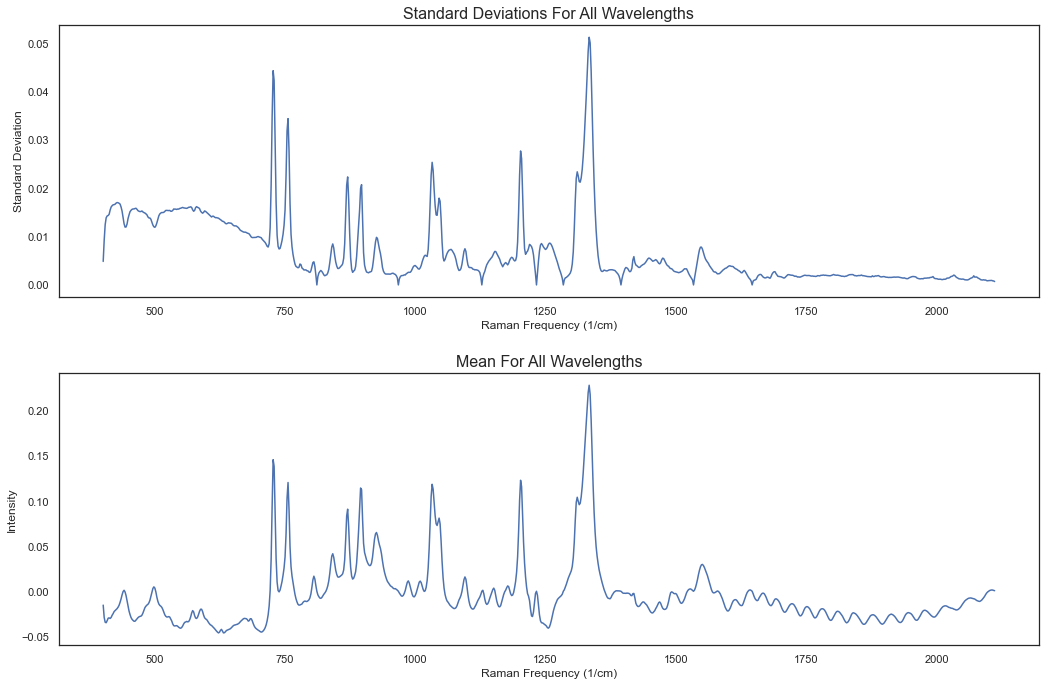

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
ax1.plot(SPEC_RANGE, X.std())
ax2.plot(SPEC_RANGE, X.mean())
ax1.set_xlabel('Raman Frequency (1/cm)')
ax2.set_xlabel('Raman Frequency (1/cm)')
ax1.set_ylabel('Standard Deviation')
ax2.set_ylabel('Intensity')
ax1.set_title('Standard Deviations For All Wavelengths', fontsize=16)
ax2.set_title('Mean For All Wavelengths', fontsize=16)
fig.tight_layout(pad=2.0)
fig.savefig('Mean_Stddev.png');

Subtracting the standard deviations and means of both the healthy and COVID positive samples gives some more insight as well. In the figure below, the strong prominent peak seen above at about 1300nm is drastically reduced. It looks as if the most likely wavelengths for identification are around 750nm with a few others showing a strong difference as well. These will likely be the wavelengths most used in PCA. 

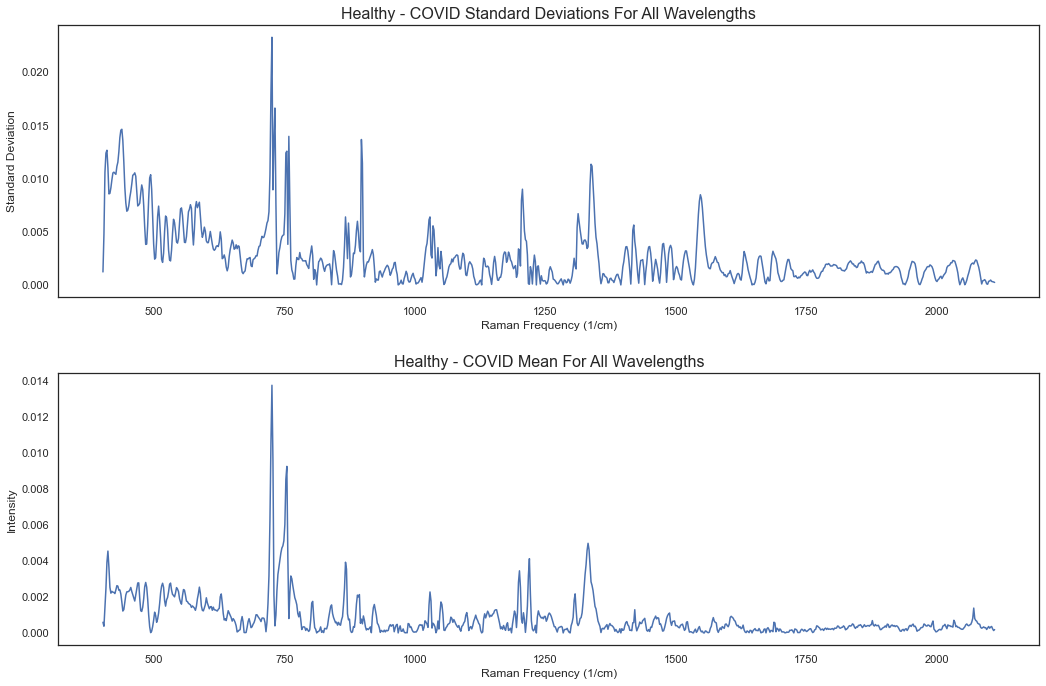

In [45]:
healthy = (df.loc[df['diagnostic'] == 'Healthy']).loc[:, '402':'2111']
COVID = (df.loc[df['diagnostic'] == 'SARS-CoV-2']).loc[:, '402':'2111']

diff_mean = abs(healthy.mean().T - COVID.mean().T)
diff_std = abs(healthy.std().T - COVID.std().T)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
ax1.plot(SPEC_RANGE, diff_mean)
ax2.plot(SPEC_RANGE, diff_std)
ax1.set_xlabel('Raman Frequency (1/cm)')
ax2.set_xlabel('Raman Frequency (1/cm)')
ax1.set_ylabel('Standard Deviation')
ax2.set_ylabel('Intensity')
ax1.set_title('Healthy - COVID Standard Deviations For All Wavelengths', fontsize=16)
ax2.set_title('Healthy - COVID Mean For All Wavelengths', fontsize=16)
fig.tight_layout(pad=2.0)
fig.savefig('Diff_plots.png');

### Scatter Corrections

As previously mentioned, the scattering effects inherent in Raman spectroscopy need to be reduced before training a model. There are two schools of thought used for reduction of scattering effects: Multiplicative Scatter Correction (MSC) and Standard Normal Variate (SNV)<sup>8</sup>. This report will use SNV. SNV is very similar to calculating z-scores, except for orientation of the scaling. SNV is scaled according to the rows as opposed to the columns with z-scores. The resulting wavelengths are shown below.

$$
SNV_X = \frac{(X-\bar{X})}{S_X}
$$

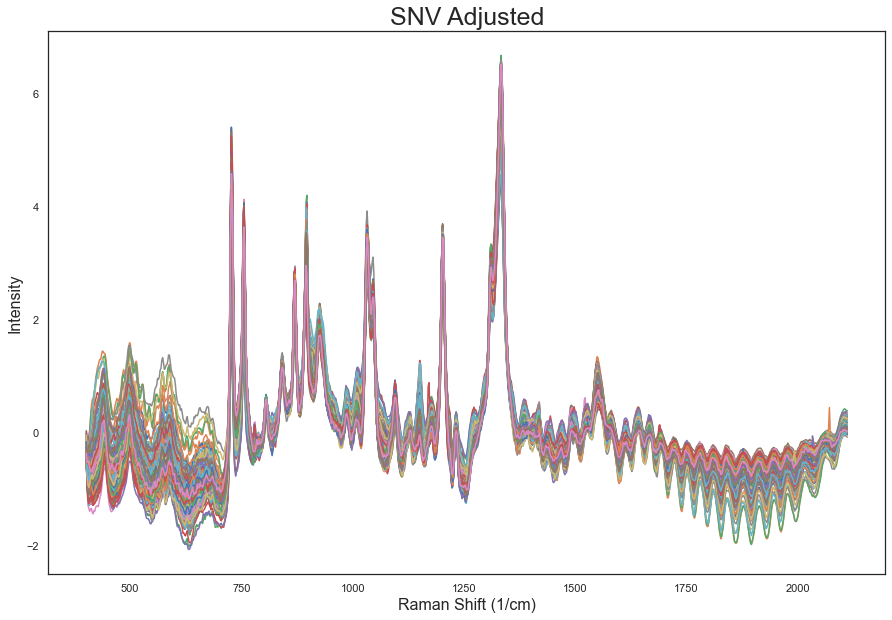

In [46]:
norm_X = ((X.T - X.T.mean()) / X.T.std()).T

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(SPEC_RANGE, norm_X.values.T)
ax.set_xlabel('Raman Shift (1/cm)', fontsize=16)
ax.set_ylabel('Intensity', fontsize=16)
ax.set_title('SNV Adjusted', fontsize=25)
fig.savefig('After_SNV.png');

With the data now centered around the mean and the heights adjusted according to standard deviation, the spectra do not appear different. In fact, the wavelengths from 1600nm onward appear to have more variation. In the end, SNV does not seem to improve the scatter effects in the spectra. The option of using Savitzky-Golay will need to be explored. 

### Savitzky-Golay Filter

Savitzky-Golay is a smoothing algorithm for noise reduction commonly used in spectroscopy preprocessing. “The filter can be used to reduce high frequency noise in a signal due to its smoothing properties and reduce low frequency signal (e.g., due to offsets and slopes) using differentiation.”<sup>9</sup> Both features will be used to maximize the clarity of the data. The `savgol_filter()` from Scipy takes four key arguments: the data set, the window length, the polynomial order, and the derivative order. The last three arguments are hyperparameters which can be tuned to provide the best result. 

Typically, with spectroscopy data, window, and polynomial order should be kept low, and the derivative should be set to 1.<sup>9</sup> Playing with the polynomial order, there was no significant difference between 1 and 2. The window size does make an obvious change when altered, but does not improve upon the model’s final accuracy, recall, or precision unless it is set to an extreme value such as ±10.  An overlapping plot showing the difference of before and after smoothing (without derivation) is seen below. 

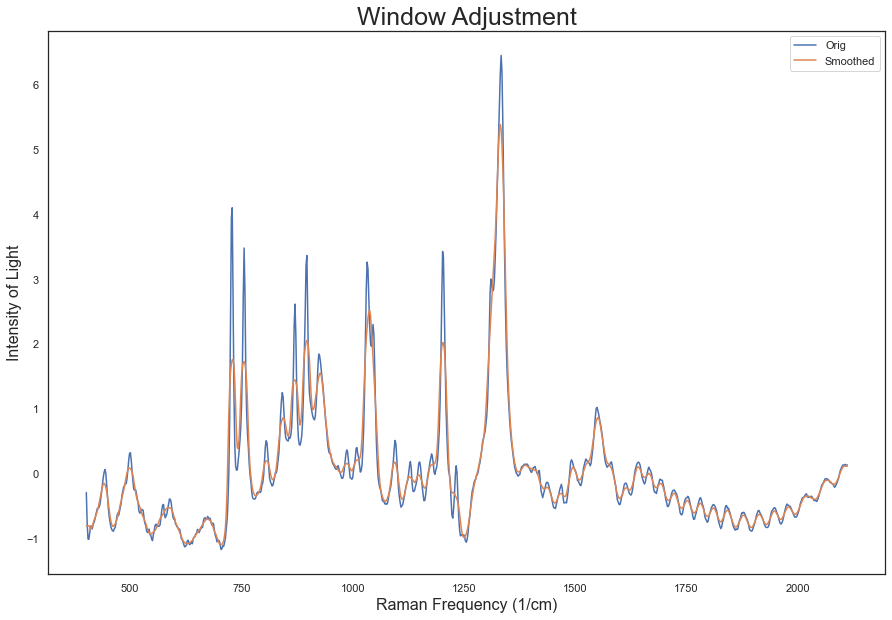

In [47]:
smoothed_X = pd.DataFrame(savgol_filter(norm_X, 9, polyorder=0, deriv=0), columns=norm_X.columns)

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(SPEC_RANGE, norm_X.iloc[10].T.values, label="Orig")
ax.plot(SPEC_RANGE, smoothed_X.iloc[10].T.values, label="Smoothed")
ax.set_xlabel('Raman Frequency (1/cm)', fontsize=16)
ax.set_ylabel('Intensity of Light', fontsize=16)
ax.set_title('Window Adjustment', fontsize=25)
ax.legend()
fig.savefig('Smoothed Comparison.png');


Adjusting <strong>X</strong> variable using Savitzky-Golay filter with derivation changes the values drastically, reducing the scattering effects by shrinking the width along the bands of all plots as seen in figure below. With the scattering effects minimized, the spectra are ready for feature reduction via PCA. While the scattering effects are improved upon, the shapes indicative of bond vibrations are now gone replaced with the slope. While the derivatization improves the PCA results, this loss of shape does hinder the possibility of revisiting certain wavelengths for bond identification. Lastly, a null check is made to ensure the data behaved properly before moving on to the analysis.

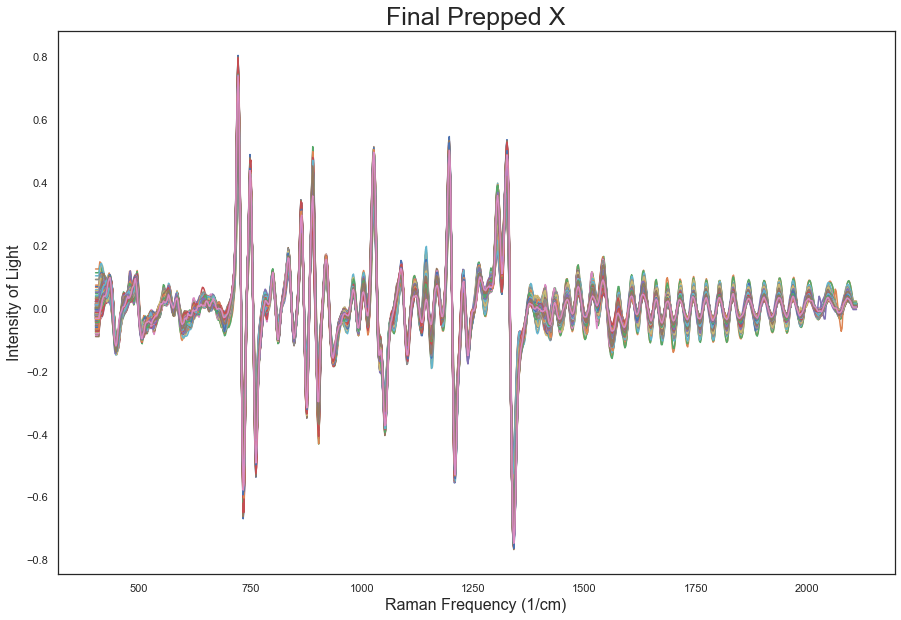

In [48]:
prepped_X = pd.DataFrame(savgol_filter(norm_X, 9, polyorder=1, deriv=1), columns=norm_X.columns)

fig, ax = plt.subplots(figsize=(15,10))

ax.plot(SPEC_RANGE, prepped_X.T.values)
ax.set_xlabel('Raman Frequency (1/cm)', fontsize=16)
ax.set_ylabel('Intensity of Light', fontsize=16)
ax.set_title('Final Prepped X', fontsize=25)
fig.savefig('Final_X.png');

In [49]:
prepped_X.isnull().sum().sum()

0

## Analysis

### Feature Reduction with PCA

Because of the high volume of features, there inherently involves a high degree of multicollinearity. This is exacerbated by the nature of the different wavelengths. While molecule bonds will vibrate dissimilarly depending on the wavelength of the light, adjacent wavelengths will still have influence on the bonds. For example, an oxygen-hydrogen bond may vibrate strongest at the wavelength x<sub>i</sub>, the wavelengths nearest will still have a vibrational effect on the bond, but to a lesser extent forming a Gaussian shape on either side. This gives a high level of multicollinearity between x<sub>i</sub> ± r wavelengths with r being some variable range. 

This makes feature reduction extremely difficult. While feature reduction typically involves deleting the features that are correlated one with another, this is unwise with spectroscopy features because many will be collinear but have different useful variation data buried within.  In chemometrics, or the use of machine learning for chemical analysis, spectroscopy features are typically reduced using some form of Principal Component Analysis, or PCA.<sup>10</sup> “PCA is a linear dimensionality reduction technique. It transforms a set of correlated variables (p) into a smaller k (k<p) number of uncorrelated variables called principal components while retaining as much of the variation in the original dataset as possible.”<sup>11</sup> Using PCA will both reduce the number of features, eliminating multicollinearity, while still retaining the variation in the data set used to distinguish changes in concentration. 

A downside to using PCA with a supervised learning technique such as logistic regression, is the absence of having a true understanding of how the components interact with model. Having replaced the wavelength features with principal components, a statistical significance cannot be attached to any of the coefficients in a meaningful way. While the principal components can be analyzed for statistical significance, there is no way of saying a certain wavelength contributed in a meaningful way. 

After PCA is performed, a logistic regression will be performed using the principal components. While logistic regression is typically used as a classification model, it is a regression technique where probabilities are used for classification. When principal components are used as the features in regression it is called Principal Component Regression, or PCR. Another widely popular technique used in chemometrics is Partial Least Squares. It is very similar to PCR but differs from it due to PLS running decomposition on the response variable as well. This allows any relationship the response variable has on the regression to be added to the model as well. However, PLS does not classify in an effective manner and is mostly used in regression techniques.<sup>10</sup>

PCA can be performed using the Scikit-learn method `PCA()`and fitting the prepared X data set. Once the data set is transformed, a few different outputs are useful for the understanding how the PCA worked. The first is observing the explained variance ratio, or how much each component explains the variance in the data. This is enhanced using the `cumsum()` method to see how they add up. These explain variance ratios can be plotted against the sequential components to see how many components are necessary—called a scree plot. The scree plot and the code are shown in the figure below. 30 components are originally chosen only as a starting point.<sup>12</sup> 

[40.78464105 66.01309945 79.64997372 85.3652905  88.61395768 89.97408165
 91.09124876 92.04653183 92.70515713 93.25820734 93.57932974 93.86842769
 94.1160634  94.35342373 94.54718435 94.7184025  94.85876828 94.99273185
 95.11310416 95.22203267 95.32912973 95.42947694 95.5265585  95.6204687
 95.7112212  95.79747554 95.87960834 95.95880401 96.03679461 96.11282527]


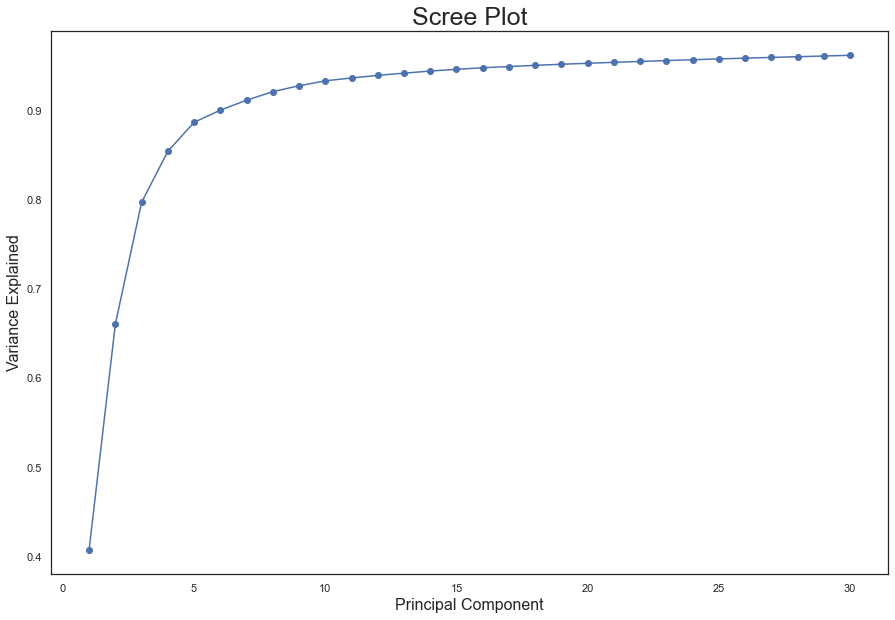

In [50]:
pca = PCA(n_components=30).fit(prepped_X)

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(range(1, 31), pca.explained_variance_ratio_.cumsum(), 'o-')
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Variance Explained', fontsize=16)
ax.set_title('Scree Plot', fontsize=25)
fig.savefig('Scree Plot.png');

print(pca.explained_variance_ratio_.cumsum()*100)

There are a few different schools of thought on how to choose the requisite number of components for analysis. One is to grab all components that explain a certain threshold of explained variance such as 80 or 90%. The first 15 principal component were chosen as it rounds up to 95% which can be reduced as necessary when analyzing the fit to a model. 

PCA also holds other information including the new components known as scores and the directions of each of the new components, or how they broke up the components by original feature, known as loadings. Due to the sheer number of features, a loadings plot will not be given, but a score plot gives some valuable insight into how well a classification might work and is shown in the figure below. A scores plot can be created and labeled according to the label given, or the y for this data set. 


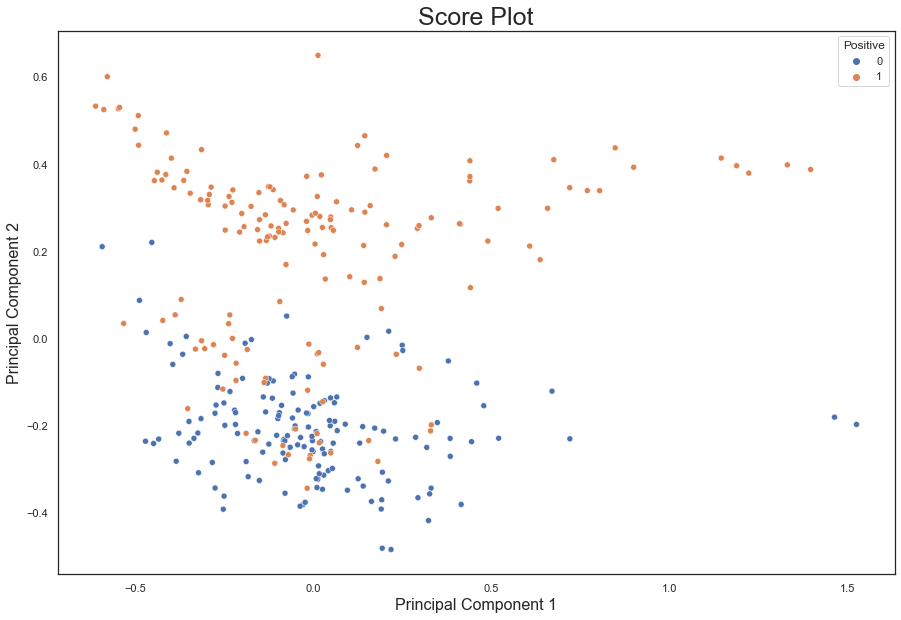

In [51]:
pca_scores = pca.fit_transform(prepped_X)

fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x=pca_scores[:,0], y=pca_scores[:,1], hue=y.Positive)
ax.set_xlabel('Principal Component 1', fontsize=16)
ax.set_ylabel('Principal Component 2', fontsize=16)
ax.set_title('Score Plot', fontsize=25)
fig.savefig('Score Plot.png')

Overlapping between the two components could be a problem. A successful scores plot will provide an obvious or relatively successful separation between the classes. Logistic regression may have issues differentiating between the two classes; however, the first two components will not be the only features used in the logistic regression. 

### Logisitic Regression

Logistic regression is a linear regression used to classify data into classes depending on probability. While a linear regression could still provide a semi-accurate classification, logistic regression takes the shape of a sigmoid, or S-shape graph where the limits of the graph are set to 0 (for 0% probability) and 1 (for 100% probability). 

While logistic regression still fits a model to the data, a major disadvantage to logistic regression, and all linear models, is the effect multicollinearity has on the model. One of the assumptions of logistic regression is not having independent features (multicollinearity) or algebraically the model will fail. Therefore, PCA was run to narrow down the number of features and eliminate multicollinearity.<sup>13</sup> 

Linear regression and logistic regression are part of the generalized linear models (GLM) family. While Statsmodels has a Logit model and a GLM available for classification, this paper opted for GLM with a specification of a Binomial subfamily in case the error distribution was not Gaussian in shape.<sup>14</sup> 

The scores are extracted from the PCA model and given column names according to principal components. A constant is added to have a y-intercept feature. `sm.add_constant()` adds a column of ones that can be multiplied by the intercept coefficient and not be altered. 

In [52]:
pca_X = sm.add_constant(pca_scores)
top_pca_X = np.array(pca_X[:,0:16])

top_pca_X = pd.DataFrame(top_pca_X, columns=['Intercept', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 
                                     'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15'])

A screening logistic regression was fitted using the Statsmodels GLM with a binomial family parameter. The purpose of this first logistic regression is to observe the coefficients, z-score, and p-values of the regression. P-values with a value greater than 0.05 can be considered statistically insignificant for feature reduction, or that the features attached to it do not contribute to the regression in a significant way and could be a candidate to be discarded. 

Looking at this first set of regression coefficients, z-scores, and p-values in the summary below, ‘PC13’, has an abnormally high p-value (well above 0.05) and a low z-score. ‘PC13’ can be dropped, another logistic regression run, and the process is repeated until all features in the regression have p-values < 0.05.  

In [53]:
first_model = sm.GLM(y, top_pca_X, family=sm.families.Binomial()).fit() 
print(first_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Positive   No. Observations:                  307
Model:                            GLM   Df Residuals:                      291
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14.335
Date:                Tue, 24 May 2022   Deviance:                       28.669
Time:                        20:35:06   Pearson chi2:                     31.5
No. Iterations:                    12   Pseudo R-squ. (CS):             0.7253
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.2144      3.716      1.672      0.0

The final logistic regression summary (below) before splitting up the data into training and testing sets shows a logistic regression where all features are statistically significant.

In [54]:
reduced_X = top_pca_X.drop(['PC13', 'PC1', 'PC9', 'PC3', 'PC4', 'PC11', 'PC14', 'PC10', 'PC7'], axis=1) #Provides a p-value of < 0.05

reduced_model = sm.GLM(y, reduced_X, family=sm.families.Binomial()).fit() 
print(reduced_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Positive   No. Observations:                  307
Model:                            GLM   Df Residuals:                      300
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26.731
Date:                Tue, 24 May 2022   Deviance:                       53.463
Time:                        20:35:06   Pearson chi2:                     95.3
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7022
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3460      1.047      4.152      0.0

‘PC1’, the feature with the most variance, was surprisingly insignificant. This is something that does occur with spectral data more often than with other data sets. Spectroscopy picks up on all chemical bonds in a sample, including those chemicals found in the background of the sample. A slight change in a solvent such as water can show up in a spectrum as a high variance. However, the concentration of water is not of importance to the target but ends up being the most principal component among all other components. 

The data is then split into training and validation sets for testing the accuracy measurements of the classification. The test size is set to 30% of all the data in the data set. 

In [55]:
X_train, X_test, y_train, y_test = train_test_split(reduced_X, y, test_size=0.3, random_state=42)

With the new training and testing sets, a final logistic regression is performed on the training set using the same logistic regression parameters as before. 

In [56]:
final_model = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()
print(final_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Positive   No. Observations:                  214
Model:                            GLM   Df Residuals:                      207
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15.708
Date:                Tue, 24 May 2022   Deviance:                       31.416
Time:                        20:35:06   Pearson chi2:                     48.0
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7088
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6024      1.946      3.393      0.0

## Data Summary and Implication

### Predictive Metrics

With classification models, the main models for testing accuracy are accuracy, recall, precision, ROC score, and confusion matrix — the basis for all the other metrics that follow. A confusion matrix is a 2x2 grid showing the counts of true positives, false positives, false negatives, and true negatives. Accuracy $\frac{(TP + TN)}{n}$ is the measure of the classifications the model accurately predicted over all sample predictions. Precision $\frac{TP}{(TP+FP)}$ is the measurement of how well the model predicts the positives. Recall $\frac{TP}{(TP+FN)}$ is important for measuring how well the model predicts a classification where a false negative can be dangerous such as a diagnosis. ROC is recall over a false positive rate $\frac{FP}{(TN+FP)}$. ROC is usually plotted in a ROC AUC plot where a perfect score is a right angled upper left. All these accuracy scores and the ROC AUC plot are shown in Figure 16 along with the corresponding code.<sup>15</sup> 

Confusion Matrix: 
 [[47  3]
 [ 0 43]] 

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        50
           1       0.93      1.00      0.97        43

    accuracy                           0.97        93
   macro avg       0.97      0.97      0.97        93
weighted avg       0.97      0.97      0.97        93

ROC AUC Score: 0.9898


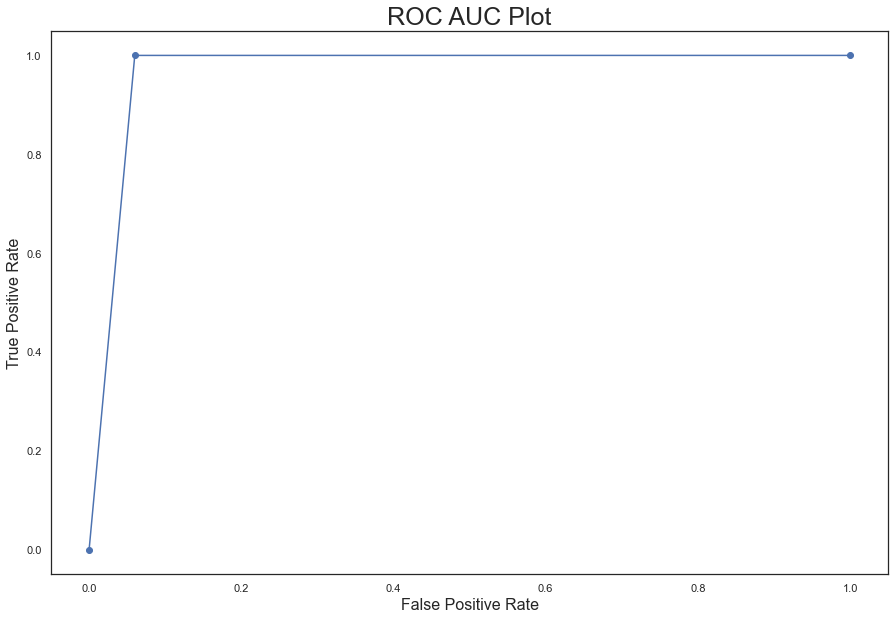

In [57]:
y_pred_prob = final_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred), "\n")
print("Classification Report: \n", classification_report(y_test, y_pred))
print("ROC AUC Score: {:.4f}".format(roc_auc_score(y_test, y_pred_prob)))

fpr, tpr, threshold = roc_curve(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(fpr, tpr, 'o-')
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title('ROC AUC Plot', fontsize=25)
fig.savefig('ROC AUC.png');

The accuracy, F1, average precision, and ROC AUC scores were right in line with the scores Chen received. While Chen did not optimize his logistic regression model for statistically significant features, he did achieve a slightly higher recall (98%) at the expense of the model robustness for future data.<sup>4</sup>  For his paper, which measures the metrics of logistic regression vs. other models, this is acceptable. Where this report strives to produce a statistically significant model, able to be utilized with future data as well, the feature screening was a necessary step. 

### Statistical Significance

Measuring a classification model’s significance is usually achieved in one of two ways, comparing the model versus a randomized set (null classifier)<sup>16</sup> or against the intercept.<sup>17</sup> This report will compare the found model against both ways to ensure the statistical significance is acceptable. 

A measurement tool commonly used for classification model comparison’s is McNemar’s test. Its basis is similar to the confusion matrix, but as opposed to having an actual value and predicted value, it has model 1 versus model 2 predictions. All sample rows are lined up along with the actual value, model 1 prediction, and model 2 predictions. The count of those predictions that are both correct when compared to the actual are placed in the upper left square. The count of those that model 1 got correct, but model 2 did not are placed in the upper right, and so on as shown in figure below accompanied with the McNemar formula. When all rows are entered into the matrix, the total count of all boxes should equal the number of rows.<sup>18</sup> 

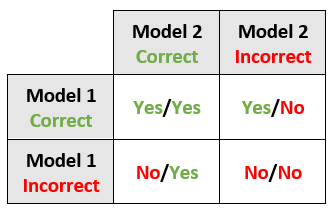


$$
McNemar Statistic = \frac{(YN - NY)^2}{YN + NY}
$$

Once the McNemar test is run, a p-value can be calculated as well. The p-value, if sufficiently low, would indicate the optimized logistic regression classification is statistically significant. Statsmodels has a McNemar test in its library which calculates the p-values and McNemar statistic. 

In [58]:
import random
from statsmodels.stats.contingency_tables import mcnemar

def random_values():
    rand = []
    for i in range(93):
        k = random.randint(0, 1)
        rand.append(k)
    return rand

def comp_v_rand(y_test, y_pred, num):
    m_stats = []
    pvals = []
    for i in range(num):
        comparison = pd.DataFrame({'Actual': np.array(y_test).flatten(),
                                   'Predicted': y_pred,
                                   'Random': random_values(),
                                   'Pred Missed': abs(np.array(y_test).flatten() - y_pred),
                                   'Rand Missed': abs(np.array(y_test).flatten() - random_values())})

        ny = (comparison[(comparison['Actual'] != comparison["Predicted"]) & 
                         (comparison['Actual'] == comparison['Random'])]).shape[0]
        yn = (comparison[(comparison['Actual'] == comparison["Predicted"]) & 
                         (comparison['Actual'] != comparison['Random'])]).shape[0]
        yy = (comparison[(comparison['Actual'] == comparison["Predicted"]) & 
                         (comparison['Actual'] == comparison['Random'])]).shape[0]
        nn = (comparison[(comparison['Actual'] != comparison["Predicted"]) & 
                         (comparison['Actual'] != comparison['Random'])]).shape[0]

        table = np.array([[yy, yn], [ny, nn]])
        result = mcnemar(table, exact=True)
        m_stats.append(result.statistic)
        pvals.append(result.pvalue)

    return pd.DataFrame({'M-stat': m_stats, 'p': pvals})

results = comp_v_rand(y_test, y_pred, 1000)
print(f'McNemar Test: {results.mean()[0]:.2f}, p-value: {results.mean()[1]:.2e}')

McNemar Test: 1.55, p-value: 7.21e-10


The first test is against random noise. This model randomly (using the random library) predicts whether the sample is a positive or negative result. The random model is then compared to the logistic regression model using McNemar statistic row-by-row. Because a single randomization could give misleading results, a series of 1000 randomized models are compared to the logistic regression. The results show that the logistic regression is statistically significant when compared against the randomized model. 

The second McNemar test is comparing the logistic regression to a logistic regression using only the intercept as a feature. The intercept from the feature-rich logistic regression X_test and X_train is brought in and fitted similarly to before. The intercept summary is shown below.

In [59]:
X_train_int = X_train['Intercept']
X_test_int = X_test['Intercept']


int_model = sm.GLM(y_train, X_train_int).fit()
print(int_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Positive   No. Observations:                  214
Model:                            GLM   Df Residuals:                      213
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                         0.24977
Method:                          IRLS   Log-Likelihood:                -154.72
Date:                Tue, 24 May 2022   Deviance:                       53.201
Time:                        20:35:09   Pearson chi2:                     53.2
No. Iterations:                     3   Pseudo R-squ. (CS):          1.095e-05
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5374      0.034     15.730      0.0

With the intercept model fitted, it would be a good idea to see the confusion matrix and accuracy metrics (below) to see how it compares to the randomized (~50% accuracy).

In [60]:
y_pred_prob_int = int_model.predict(X_test_int)
y_pred_int = (y_pred_prob_int > 0.5).astype(int)

print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_int), "\n")
print("Classification Report: \n", classification_report(y_test, y_pred_int))
print("ROC AUC Score: {:.4f}".format(roc_auc_score(y_test, y_pred_prob_int)))

Confusion Matrix: 
 [[ 0 50]
 [ 0 43]] 

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.46      1.00      0.63        43

    accuracy                           0.46        93
   macro avg       0.23      0.50      0.32        93
weighted avg       0.21      0.46      0.29        93

ROC AUC Score: 0.5000


C:\Users\kylel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kylel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kylel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The accuracy is right around the 50% mark, about the same as the randomized model. The McNemar calculation (below) should now give an idea on how the feature-rich logistic regression model compares to the intercept logistic regression model. The optimized logistic regression model performed even better compared to the intercept model than when compared to the randomized model.

In [61]:
def comp_v_int(y_test, y_pred, y_pred_int):
    comparison = pd.DataFrame({'Actual': np.array(y_test).flatten(),
                               'Predicted': y_pred,
                               'Intercept': y_pred_int,
                               'Pred Missed': abs(np.array(y_test).flatten() - y_pred),
                               'Int Missed': abs(np.array(y_test).flatten() - y_pred_int)})

    ny = (comparison[(comparison['Actual'] != comparison["Predicted"]) & 
                     (comparison['Actual'] == comparison['Intercept'])]).shape[0]
    yn = (comparison[(comparison['Actual'] == comparison["Predicted"]) & 
                     (comparison['Actual'] != comparison['Intercept'])]).shape[0]
    yy = (comparison[(comparison['Actual'] == comparison["Predicted"]) & 
                     (comparison['Actual'] == comparison['Intercept'])]).shape[0]
    nn = (comparison[(comparison['Actual'] != comparison["Predicted"]) & 
                     (comparison['Actual'] != comparison['Intercept'])]).shape[0]

    table = np.array([[yy, yn], [ny, nn]])
    result = mcnemar(table, exact=True)
    print(f'McNemar Test: {result.statistic:.2f}, p-value: {result.pvalue:.2e}')

comp_v_int(y_test, y_pred, y_pred_int)

McNemar Test: 0.00, p-value: 1.42e-14


### Hypothesis Revisited

At the beginning of the paper, the hypothesis was outlined as:

H<sub>O</sub>: Logistic regression cannot predict if a sample contains COVID in a statistically significant manner.               

H<sub>A</sub>: Logistic regression can predict if a sample contains COVID in a statistically significant manner.

The McNemar statistic was used to find p-values comparing the optimized logistic regression classifier to the intercept model and randomize model. Often, the p-value threshold to show statistical significance is set to 0.05, because this is of medical importance, there is no room for error. The author has set the maximum p-value as 0.001. Even still, the optimized logistic regression has a p-value lower than the threshold when compared to the two models, thus the null hypothesis is rejected, and the logistic regression model can be said to be statistically significant. 

## Conclusion

The question this paper attempted to answer was, can logistic regression provide a statistically significant prediction model for diagnosing whether a patient is infected with COVID-19 to help reduce misdiagnoses and provide proper care for the patient? From the discussion of the hypothesis above, it can be concluded that the optimized logistic regression is statistically significant and thus can be used as a method for diagnose whether a sample contains strands of the COVID-19 virus.

Unfortunately, due to the sheer number of features (wavelengths), PCA needed to be run to reduce the number of features for classification while still maintaining the variance. This eliminated the possibility of tracking the wavelengths to the exact bonds or compounds which give the model significance. While the principal components give a better model fit, they reduce the information accessible through fitting a classification model. A future report could attempt to fit a classification model using only the wavelengths with a robust feature selection tool such as forward feature selection or a hybrid approach.<sup>19</sup> 

While the logistic regression model was extremely accurate at 97%, when it comes to medical diagnoses, no accuracy under 100% should be acceptable. In Chen’s paper, an ensemble method outperformed logistic regression and a support vector classification matched the logistic regression as well. Both models could be the focus of a future study to improve upon the model output and reduce the risk of misdiagnoses. 

With the optimized logistic regression being statistically significant and relatively accurate, this model could be used for future COVID-19 serum sample testing. It would provide a cheaper, rapid, non-destructive, alternative testing method to support the RT-qPCR and ELISA testing methods. While the accuracy is not as trustworthy as the golden standards of these two methods, it does provide a relatively reliable method for a fraction of the price after initial purchase of the Raman spectrometer. 


## Resources

1)	Worldometer. Accessed April 13, 2022. <https://www.worldometers.info/coronavirus/>.

2)	“Basic Principles of RT-qPCR.” ThermoFisher Scientific. Accessed on April 12, 2022. <https://www.thermofisher.com/us/en/home/brands/thermo-scientific/molecular-biology/molecular-biology-learning-center/molecular-biology-resource-library/spotlight-articles/basic-principles-rt-qpcr.html>.

3)	Yin G, Li L, Lu S, et al. “An efficient primary screening of COVID-19 by serum Raman spectroscopy”, J Raman Spectrosc. 2021;1–10. https://doi.org/10.1002/jrs.6080. 

4)	David Chen (2021) “Analysis of Machine Learning Methods for COVID-19 Detection Using Serum Raman Spectroscopy”, Applied Artificial Intelligence, 35:14, 1147-1168, DOI: 10.1080/08839514.2021.1975379

5)	Santos, Francis. “Raman Spectroscopy for Detecting COVID-19”, Kaggle, Accessed April 4, 2022. < https://www.kaggle.com/datasets/sfran96/raman-spectroscopy-for-detecting-covid19/metadata?resource=download&select=covid_and_healthy_spectra.csv >.

6)	“Getting Started.” Scikit-learn. Accessed on April 14, 2022. <https://scikit-learn.org/stable/getting_started.html>.

7)	Hiregoudar, Shravankumar. “Scatter Correction and Outlier Detection in NIR Spectroscopy.” Towards Data Science. Accessed April 15, 2022. <https://towardsdatascience.com/scatter-correction-and-outlier-detection-in-nir-spectroscopy-7ec924af668>.

8)	Pelliccia, Daniel. “Two Scatter Correction Techniques for NIR Spectroscopy in Python.” NIRPY Research. Accessed April 15, 2022. <https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/>.

9)	Gallagher, Neal B. (2013) “Savitzky-Golay Smoothing and Differentiation Filter.” Eigenvector Research Inc. 

10)	Biancolillo A and Marini F (2018) Chemometric Methods for Spectroscopy-Based Pharmaceutical Analysis. Front. Chem. 6:576. doi: 10.3389/fchem.2018.00576.

11)	Pramoditha, Rukshan. “Principal Component Analysis (PCA) with Scikit-learn.” Towards Data Science. Accessed April 9, 2022. <https://towardsdatascience.com/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0>.

12)	Zach. “How to Create a Scree Plot in Python (Step-by-step).” Statology. Accessed April 9, 2022. <https://www.statology.org/scree-plot-python/>.

13)	Rout, Amiya. “Advantages and Disadvantages of Logistic Regression.” Geeks for Geeks. Accessed April 19, 2022. < https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/>.

14)	Kida, Yuho. “Generalized Linear Models.” Towards Data Science. Accessed April 18, 2022. <https://towardsdatascience.com/generalized-linear-models-9cbf848bb8ab>.

15)	Agarwal, Rahul. “The 5 Classification Evaluation Metrics Every Data Scientist Must Know.” Towards Data Science. Accessed April 19, 2022. <https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226>.

16)	Dietterich, Thomas (1997) Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithms. Neural Computation. 10:7. doi: 10.1162/089976698300017197.

17)	Harrell, Frank. “How to assess statistical significance of the accuracy of a classifier?” Stack Overflow. Accessed April 22, 2022. <https://stats.stackexchange.com/questions/17408/how-to-assess-statistical-significance-of-the-accuracy-of-a-classifier>.

18)	Brownlee, Jason. “How to Calculate McNemar’s Test to Compare Two Machine Learning Classifiers.” Machine Learning Mastery. Accessed April 11, 2022. <https://machinelearningmastery.com/mcnemars-test-for-machine-learning/>.

19)	James, G, Witten D, Hastie, T, Tibshirani, R. “An Introduction to Statistical Learning.” New York City. Springer. 2017.